<a href="https://colab.research.google.com/github/JakeFiler/fromTheGround/blob/main/firstSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
#Quadratic function for a parabola
def f(x):
  return 3*x**2 - 4*x + 5

In [127]:
#where x is 3.0 where

f(3.0)

20.0

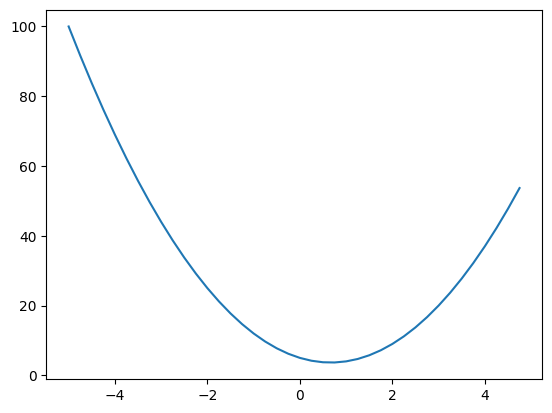

In [128]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

The **derivative** represents the rate of change of a function.
For a curve, the slope isn't constant—it changes at every point. The **derivative** gives the slope of the curve at a specific point. We call this the **instantaneous rate of change**.


In [129]:
h = 0.000000001 # bring this closer to zero and converge to the exact amount (run)
x = 2/3 # the point at which im interested in the derivative of the funciton
f(x+h) # change x an very small amount
f(x+h)-f(x) # what happened to x beacuse of the changes applied by h? (this is the rise)
(f(x+h)-f(x))/h # the approximation of the slope of the tangent line or the IRC(rise/run)

0.0

In [130]:
# turning up the heat
# derivitave of a function with mutltiple inputs
h = 0.000000001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [131]:
h = 0.000000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(d1)
print(d2)
print((d2 - d1)/h)

4.0
3.9999999969999998
-3.000000248221113


In [168]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d * f; L.label = 'L'

d

Value(data=4.0)

This is giving the children of the d
(value resulting from a*b) and c

In [133]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

The **operation** used to get the value

In [134]:
d._op

'+'

In [135]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



This is the visualization of the **Forward Pass**

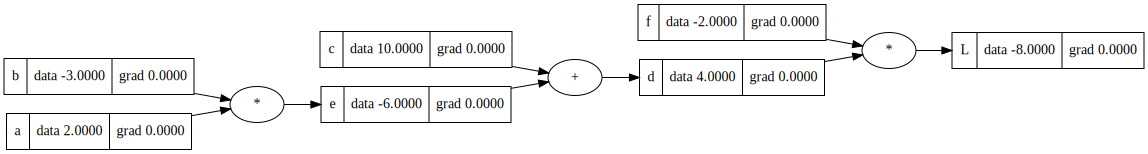

In [136]:
draw_dot(L)

In [137]:
#nudging the leaf notes in some direction to see what happens to L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print (L.data)

-8.0


Manual Backpropagation

We want to know the derivitive of d with respect to L
L = d * f view above plot

dL/dd = f  the answer

the proof
(f(x+h)-f(x))/h

(d+h)*f - d*f / h
df + hf - df / h  -> df-df cancels
hf/h
f

Here the derivative of d with respect to L is f
and the derivative of f with respect to L is d


In [138]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4

In [139]:
c.grad = -2
e.grad = -2

Chain Rule Time
If a car is twice as fast as a bike, and a bike is 4 times as fast as a walking man, then the car travels 8 times faster than the man

z = car
y = bicycle
x = man

The rate of change of the relative positions of the car and the walking man is equal to the rate of change of the relative positions of car to the bike times the bike to the man.

dz/dx = dz/dy * dy/dx

2 * 4 = 8

The important part here is how can we get the derivitive of L with respect to c

How is L sensitive to c

If we can figure out how c impacts d, then how d impacts L then we should be able to get it

dd/dc = 1.0
dd/de = 1.0
d = c + e

WANT:
dL / dc = (dL / dd) * (dd/dc)

KNOW:
dL / dd
dd / dc




In [140]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

dL / de = -2.0

e = a * b
de / da? b

dL / da = (dL / de) * (de / da)


In [141]:
# Inline Gradient Check
# Deriving the backpropagation and getting the derivative with respect
# to all the intermidiate results
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-4.000000000026205


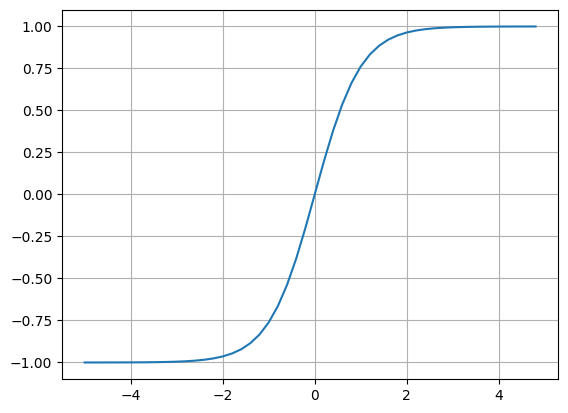

In [142]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [143]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


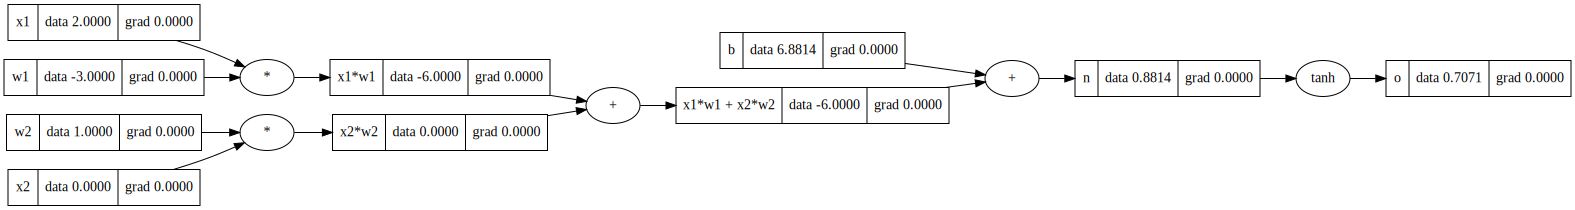

In [144]:
draw_dot(o)

In [145]:
o.backward()

In [146]:
o.grad = 1.0

In [147]:
o._backward()

In [148]:
n._backward()

In [149]:
b._backward()

In [150]:
x1w1x2w2._backward()

In [151]:
x2w2._backward()
x1w1._backward()

In [152]:
import torch

In [153]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [154]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



Value(data=0.5586536939952655)

In [331]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.15010490564314036)

In [227]:
n.parameters()

[Value(data=0.7792178490309132),
 Value(data=-0.10691303693958787),
 Value(data=0.06856875421485276),
 Value(data=-0.9738299183692223),
 Value(data=-0.8848520444284413),
 Value(data=0.9638284223209974),
 Value(data=0.6913352650153604),
 Value(data=0.4069716097518328),
 Value(data=0.7124119851609352),
 Value(data=0.7711434063731579),
 Value(data=0.14829695264543452),
 Value(data=0.2472601591679302),
 Value(data=0.06999122427187054),
 Value(data=-0.8371295356002535),
 Value(data=0.594721872361089),
 Value(data=-0.9263267465531873),
 Value(data=-0.5609051803568799),
 Value(data=0.05135245124358656),
 Value(data=-0.36821180179864177),
 Value(data=-0.4041490213770409),
 Value(data=-0.15363472690266677),
 Value(data=-0.550315154112883),
 Value(data=0.12272898607233129),
 Value(data=-0.573983801514544),
 Value(data=0.34877945374935804),
 Value(data=0.8369677552651733),
 Value(data=0.12394514211291718),
 Value(data=0.3151253454666634),
 Value(data=-0.9177628484933571),
 Value(data=0.4318733011

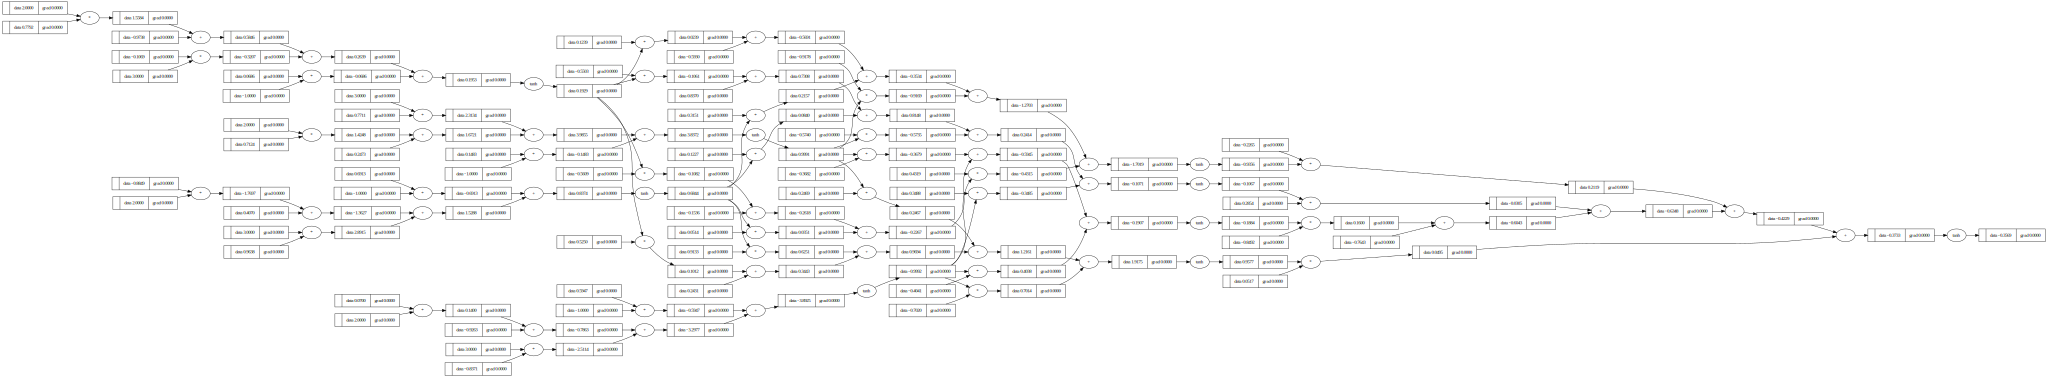

In [228]:
draw_dot(n(x))

In [332]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [355]:
# Gradient descent training loop
for k in range(20):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)




0 0.0011538526972961457
1 0.0011509229530515144
2 0.001148007724074683
3 0.0011451069037394627
4 0.0011422203864562067
5 0.0011393480676592067
6 0.0011364898437944226
7 0.0011336456123072877
8 0.0011308152716306993
9 0.0011279987211732338
10 0.0011251958613074826
11 0.0011224065933585691
12 0.0011196308195928258
13 0.0011168684432066407
14 0.0011141193683154636
15 0.0011113834999429304
16 0.0011086607440102193
17 0.0011059510073254519
18 0.0011032541975733623
19 0.0011005702233049795


In [356]:
ypred

[Value(data=0.9844562265300294),
 Value(data=-0.9831114283047593),
 Value(data=-0.9882754197206606),
 Value(data=0.9791128821282769)]